# *Maternal Mortality Risk Analysis: Exploring Factors Impacting Maternal Well-being*

## Introduction


Maternal health risk can be defined as the health of a mother during pregnancy, childbirth and postnatal period. 287,000 mothers died during or after pregnancy and childbirth in 2020. Being able to create a predictive model using all these variables will be beneficial in preventing these deaths. 


The predictive question we will try to answer is: **Given a patient’s health-related measurements on 6 different variables (age, systolic blood pressure, diastolic blood pressure, blood glucose, body temperature, heart rate), can we predict the risk level for maternal mortality as low, medium, or high?** We will also investigate which factors are most strongly associated with high maternal risk in the dataset.


Our dataset has seven variables, one of them being the risk level we are trying to predict. The other 6 variables are 
- age
- systolic blood pressure
- diastolic blood pressure
- blood glucose
- body temperature
- heart rate


These variables can be used as predictor variables for our final prediction. 


Our database is https://archive.ics.uci.edu/dataset/863/maternal+health+risk


## Preliminary exporatory Data Analysis

In [41]:
# Import necessary libraries

library(rvest)
library(tidyverse)
library(tidymodels)
library(repr)

### Reading the dataset from the web into R

The dataset we have chosen is hosted on a website which does not have a supported R API.

The file is stored in .zip format so we cannot pass the file url directly to `read_csv()`.

Instead, we will download the zip, extract the csv and then pass it to `read_csv()`

In [42]:
# Part 1
# - Retrieve source code of website
# - Use CSS selectors to get the `<a></a>` elment that contains the link to the file
# - Extract the url which is held in the `href` attribute of the `<a></a>` tag

dataset_website_root <- "https://archive.ics.uci.edu"
dataset_webpage_url <- "/dataset/863/maternal+health+risk"

page = paste(dataset_website_root, dataset_webpage_url, sep = "") |>
    read_html()   # Contains html source code of website

selectors <- paste(".btn-primary.btn.w-full.text-primary-content", sep = ",")    # CSS selectors created inspecting the download button 

population_nodes <- html_nodes(page, selectors)  # Contains all the elements that match the CSS selector criteria (only the button we want)

file_url <- population_nodes |> html_attr("href")    # Gets the href of the download button (filepath of dataset file relative to the website root)

download_url <- paste(dataset_website_root, file_url, sep = "") # Url of webpage + path to file

download_url

[1] "https://archive.ics.uci.edu/static/public/863/maternal+health+risk.zip"

In [43]:
# Part 2
# - Download the dataset file pointed to by the url
# - Extract the .zip file containing the dataset csv
# - Read the csv file into R

temp <- tempfile() # Create a temporary file to store the zip

download.file(download_url,temp) # Download the zip file from the website and store it in the temporary file

original_name <- unzip(temp) # Extract and save the csv file from the zip
unlink(temp) # Remove the temporary zip file

new_filename <- "maternal_health.csv" # improved filename removing whitespaces

file.rename(original_name, new_filename) # Rename the file to be easier to access and removing whitespace in the original name

maternal_health <- read_csv(new_filename) # Read the csv file into R

[1] TRUE

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Using local files
If the file already exists on our local machine, it can simply be read using the `read_*` function on the filepath, depending on the type of file (`read_csv()` in our case)

In [44]:
maternal_health <- read_csv("maternal_health.csv")

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Cleaning and Wrangling the data

#### Tidying data

Our dataset is already tidy since it fulfils the 3 criteria for tidy data.

#### Splitting the data into training and test data

We will split the data into two parts. 75% will be used as training data and 25% will be used as test data.

In [45]:
# Renaming Columns to make them easier to manage
new_col_names <- c("age", 
                    "systolic_blood_pressure", 
                    "diastolic_blood_pressure", 
                    "blood_glucose", 
                    "body_temperature", 
                    "heart_rate", 
                    "risk_level")
old_col_names <- colnames(maternal_health)
maternal_health <- maternal_health |> 
    rename_at(old_col_names, ~ new_col_names)

# Settng risk_level as the factor
maternal_health <- maternal_health |> 
    mutate(risk_level = as_factor(risk_level)) |>
    mutate(risk_level = fct_recode(risk_level, "high" = "high risk", "low" = "low risk", "mid" = "mid risk"))

# Splitting the data 

maternal_health_split <- maternal_health |>
    initial_split(prop = 0.75, strata = risk_level) # Split the data 3:1


maternal_health_train <- training(maternal_health_split) # Assign the training data to maternal_health_train
maternal_health_test <-testing(maternal_health_split) # Assign the testing data to maternal_health_test

glimpse(maternal_health_train)

Rows: 760
Columns: 7
$ age                      <dbl> 25, 29, 30, 23, 35, 50, 25, 40, 48, 23, 34, 5…
$ systolic_blood_pressure  <dbl> 130, 90, 140, 140, 85, 140, 140, 140, 140, 14…
$ diastolic_blood_pressure <dbl> 80, 70, 85, 80, 60, 90, 100, 100, 90, 90, 60,…
$ blood_glucose            <dbl> 15.00, 8.00, 7.00, 7.01, 11.00, 15.00, 7.01, …
$ body_temperature         <dbl> 98, 100, 98, 98, 102, 98, 98, 98, 98, 98, 102…
$ heart_rate               <dbl> 86, 80, 70, 70, 86, 90, 80, 90, 90, 70, 86, 9…
$ risk_level               <fct> high, high, high, high, high, high, high, hig…


### Summarizing the data using training data

We first show a summary of the number and percentage of the three categories, high risk, low risk and medium risk.

Secondly, we show a table of the mean values for all our variables

In [46]:
total_number <- nrow(maternal_health_train)

maternal_health_count_categories <- maternal_health_train |>
    group_by(risk_level) |>
    summarize(count = n(), percentage = round((n() / total_number) * 100))

maternal_health_variable_means = maternal_health_train |>
    summarize(across(age:heart_rate, \(x) mean(x, na.rm = TRUE)))

#### Summary of the distribution of high risk, low risk and medium risk for maternal mortality 

In [47]:
maternal_health_count_categories

risk_level,count,percentage
<fct>,<int>,<dbl>
high,204,27
low,304,40
mid,252,33


#### Summary of the mean of the different variables affecting maternal mortality

In [48]:
maternal_health_variable_means 

age,systolic_blood_pressure,diastolic_blood_pressure,blood_glucose,body_temperature,heart_rate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30.12895,113.2039,76.41579,8.746263,98.64579,74.21053


### Visualisation using training data

We have made graphs to illustrate the variables and how they have an affect on the category.

In [49]:
maternal_health_train |> select(-risk_level) |> cor()

,age,systolic_blood_pressure,diastolic_blood_pressure,blood_glucose,body_temperature,heart_rate
age,1.00000000,0.42368141,0.39727487,0.4690321,-0.2460138,0.07290232
systolic_blood_pressure,0.42368141,1.00000000,0.78225131,0.4188694,-0.2665386,-0.02400843
diastolic_blood_pressure,0.39727487,0.78225131,1.00000000,0.4207683,-0.2351471,-0.04446058
blood_glucose,0.46903212,0.41886942,0.42076826,1.0000000,-0.1102083,0.15273921
body_temperature,-0.24601378,-0.26653860,-0.23514708,-0.1102083,1.0000000,0.10687019
heart_rate,0.07290232,-0.02400843,-0.04446058,0.1527392,0.1068702,1.00000000


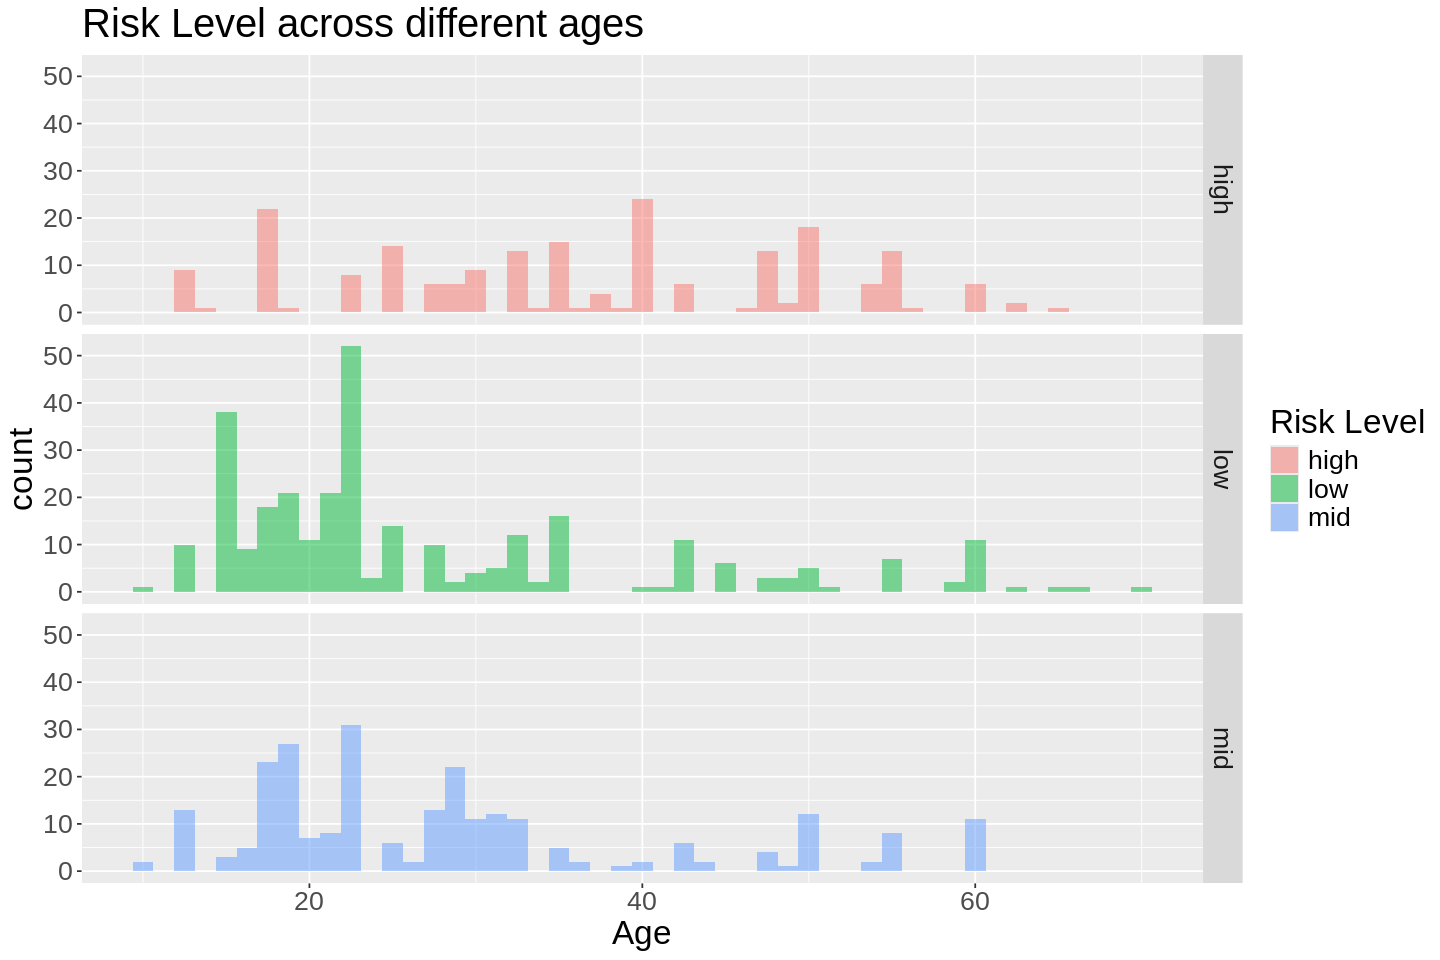

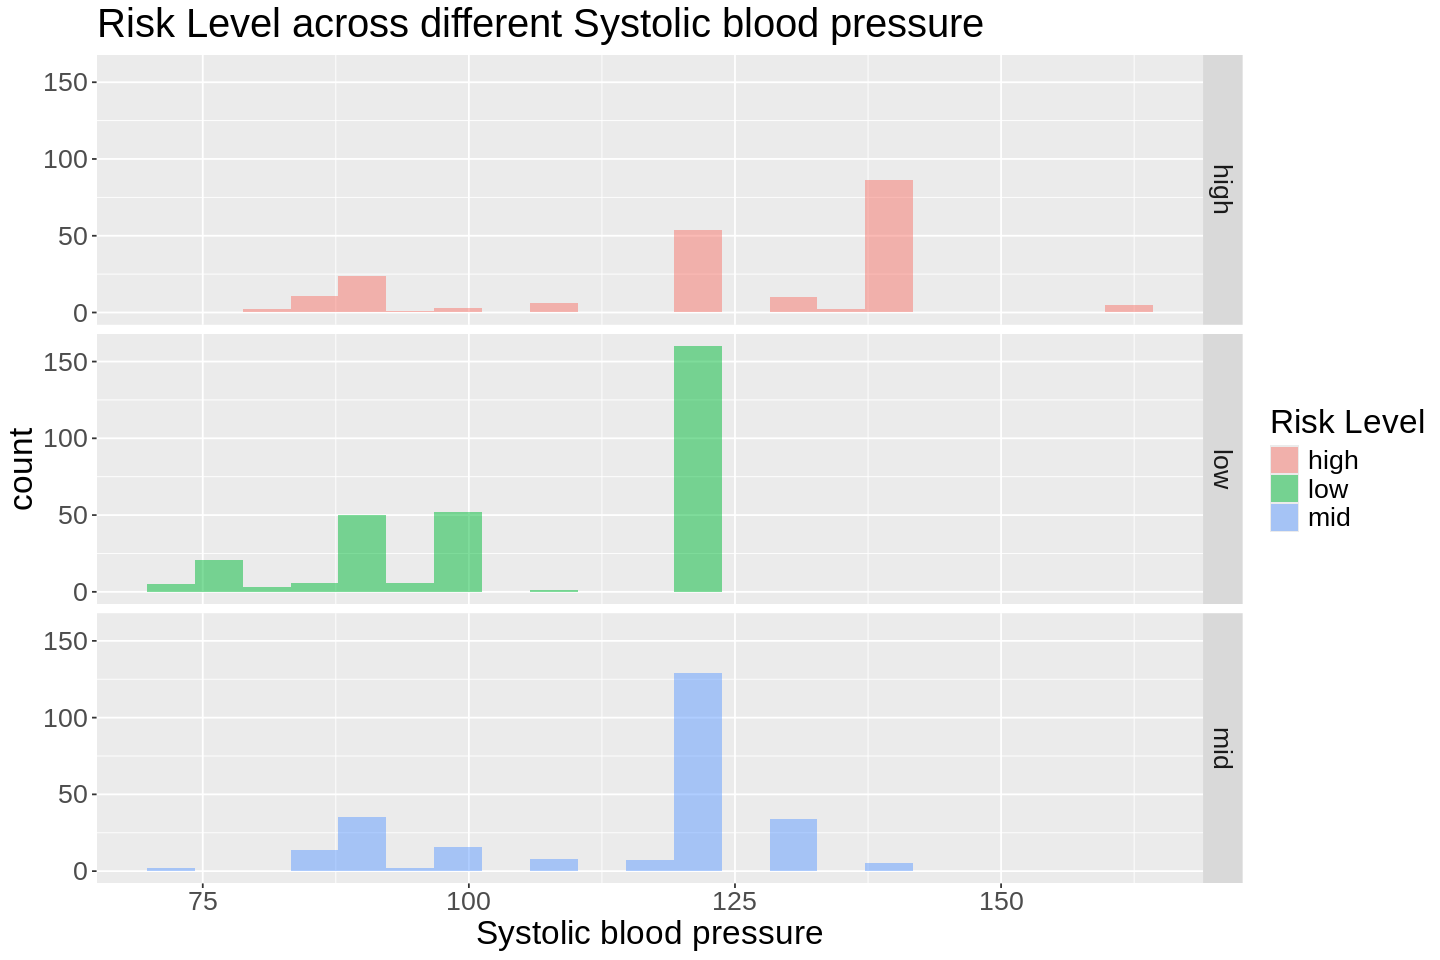

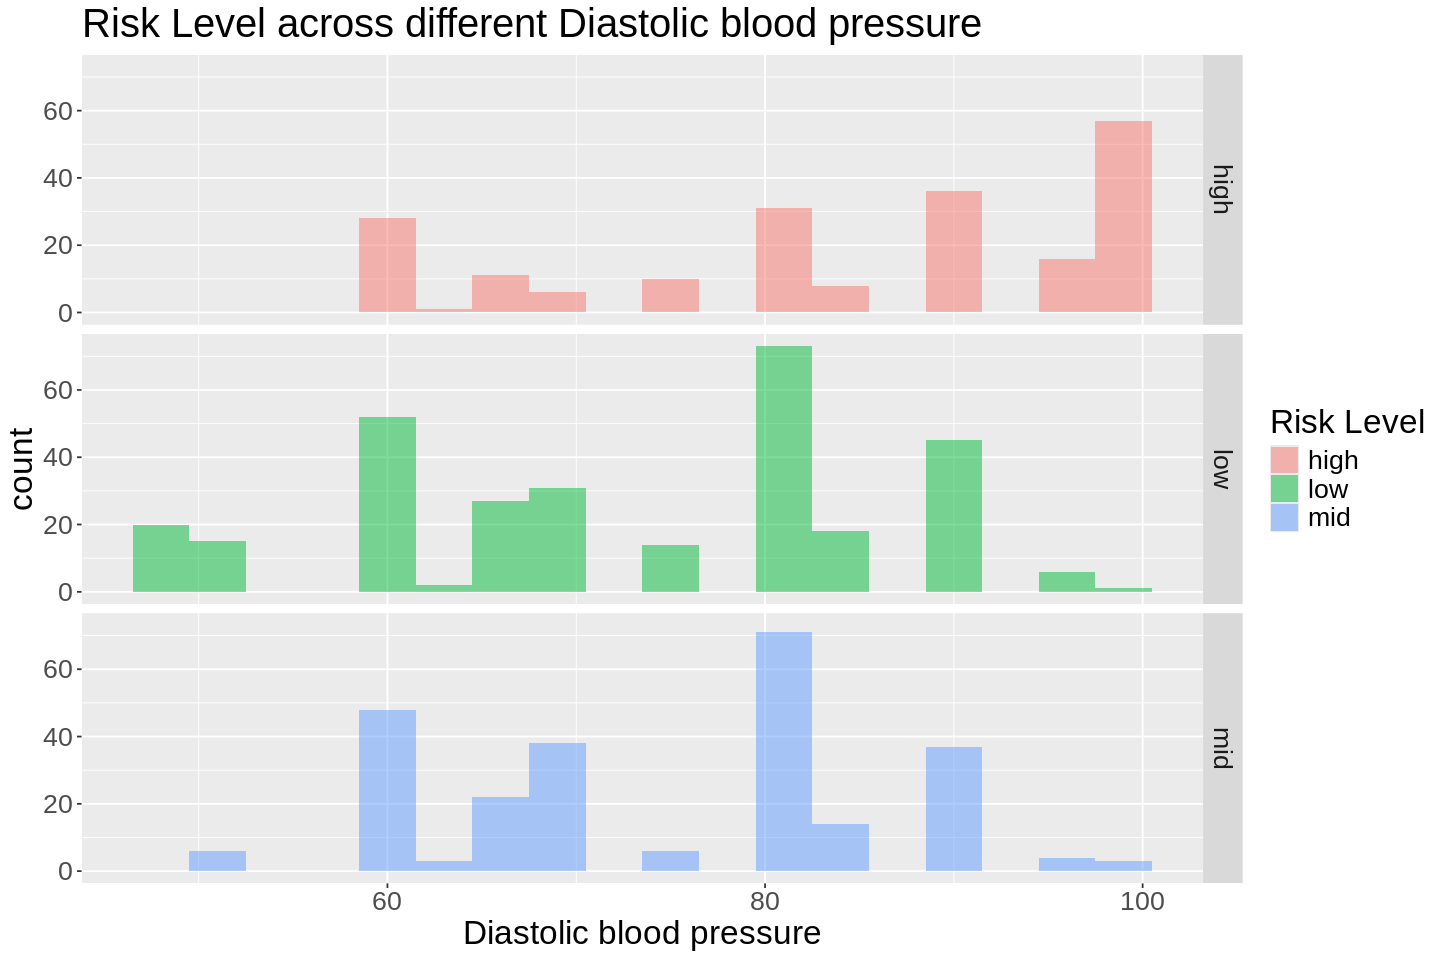

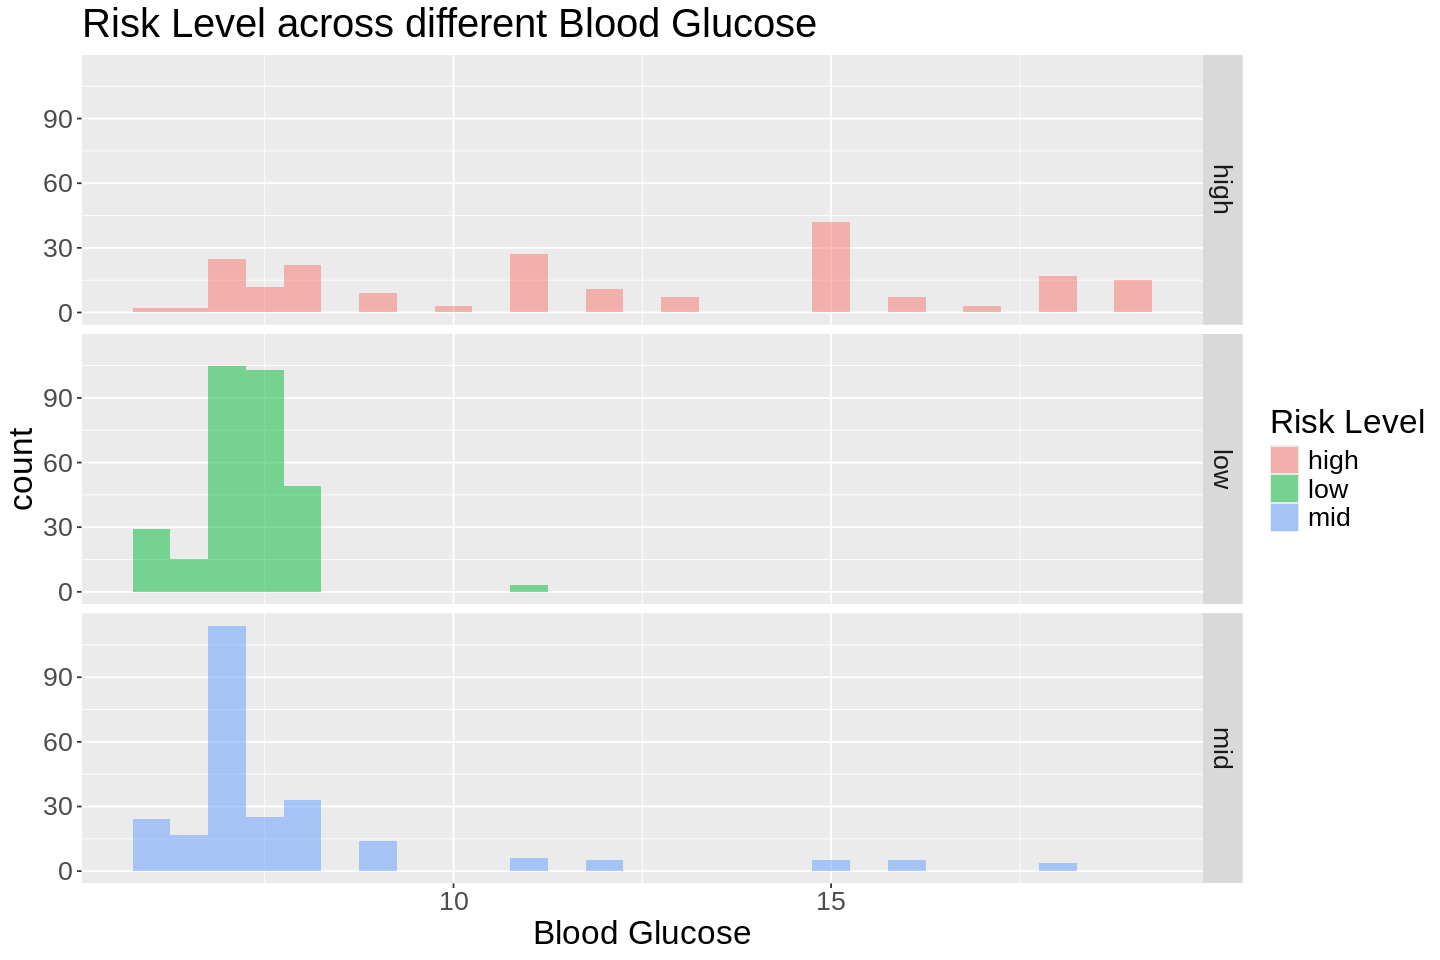

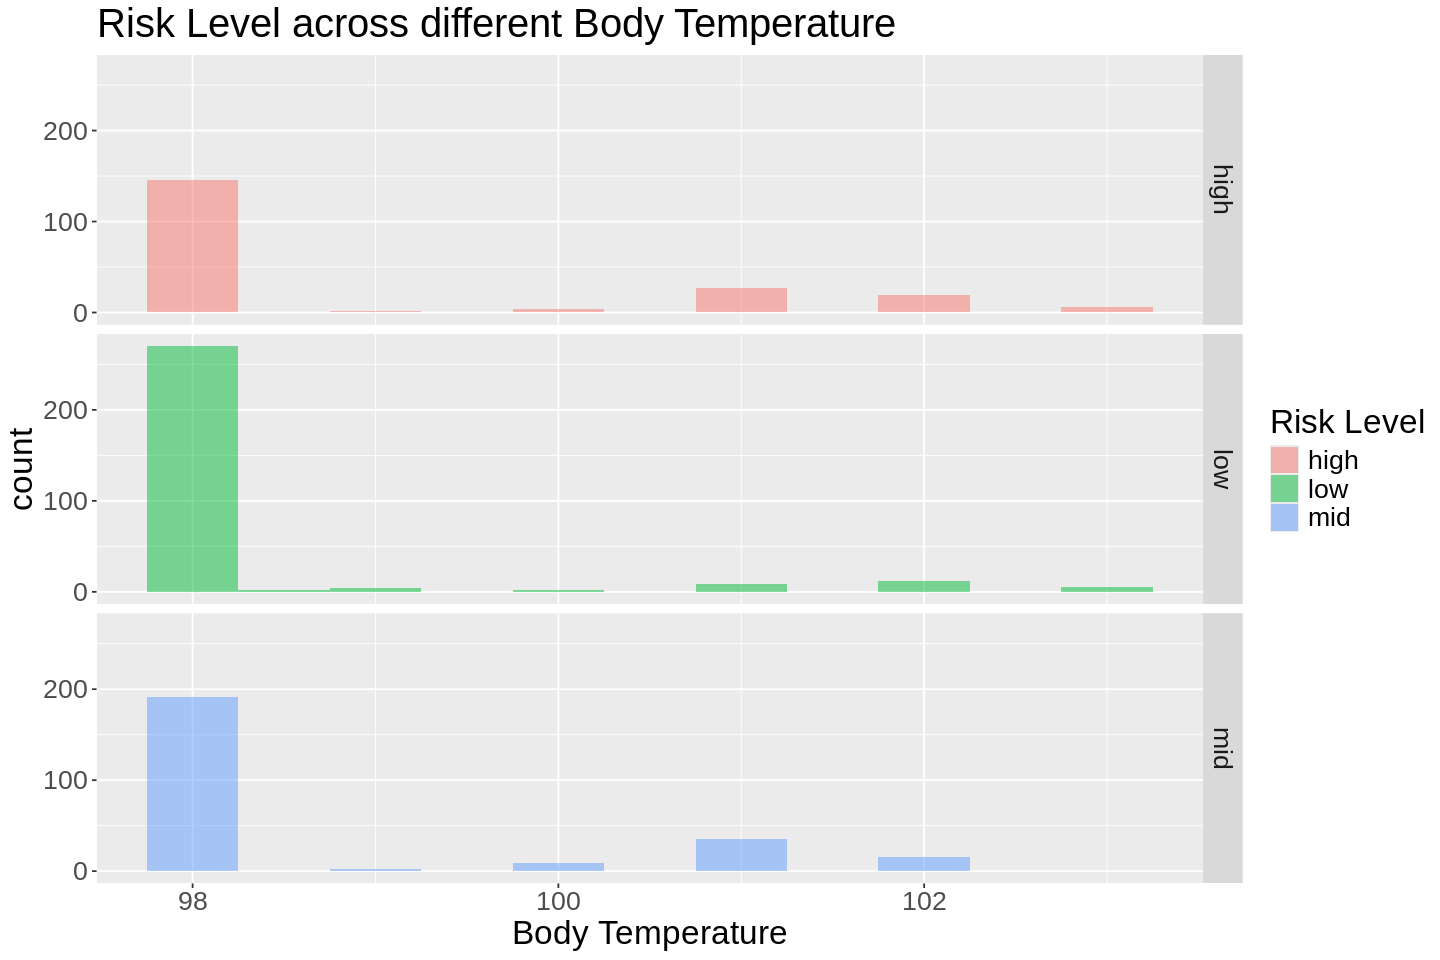

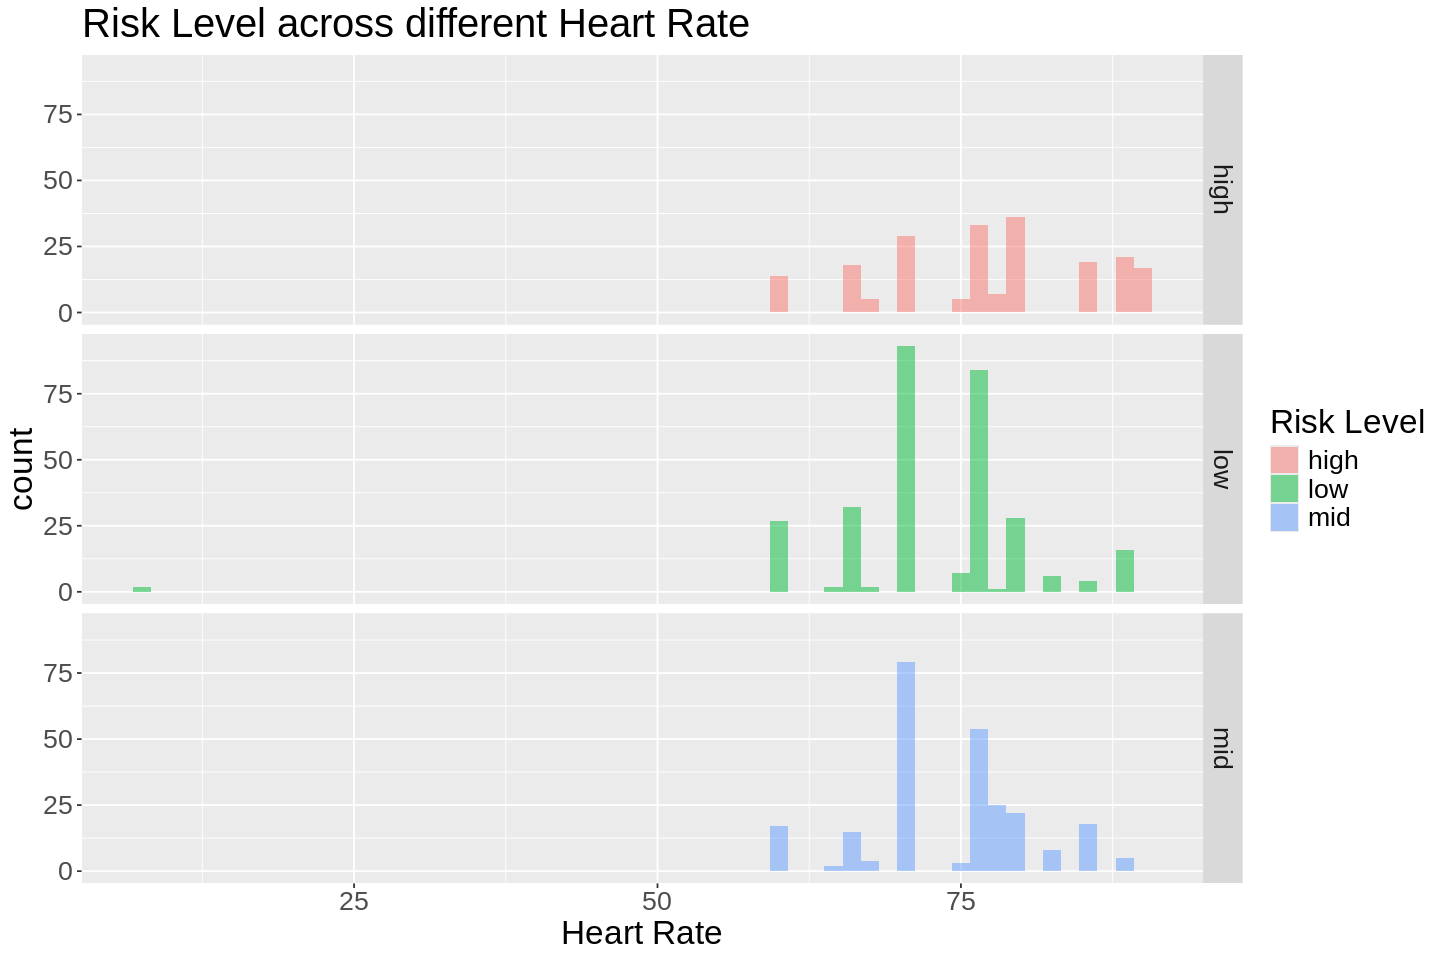

In [50]:
options(repr.plot.width = 12, repr.plot.height = 8) 

maternal_health_train |>
    ggplot(aes(x = age, fill = as_factor(risk_level))) + geom_histogram(alpha = 0.5, position = "identity", binwidth = 1.25) +  facet_grid(rows = vars(risk_level)) +
    labs(x = "Age", title = "Risk Level across different ages", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = systolic_blood_pressure, fill = as_factor(risk_level))) + geom_histogram(alpha = 0.5, position = "identity", binwidth = 4.5) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Systolic blood pressure", title = "Risk Level across different Systolic blood pressure", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = diastolic_blood_pressure, fill = as_factor(risk_level))) + geom_histogram(alpha = 0.5, position = "identity", binwidth = 3) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Diastolic blood pressure", title = "Risk Level across different Diastolic blood pressure", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = blood_glucose, fill = as_factor(risk_level))) + geom_histogram(alpha = 0.5, position = "identity", binwidth = 0.5) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Blood Glucose", title = "Risk Level across different Blood Glucose ", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = body_temperature, fill = as_factor(risk_level))) + geom_histogram(alpha = 0.5, position = "identity", binwidth = 0.5) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Body Temperature", title = "Risk Level across different Body Temperature", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = heart_rate, fill = as_factor(risk_level))) + geom_histogram(alpha = 0.5, position = "identity", binwidth = 1.5) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Heart Rate", title = "Risk Level across different Heart Rate", fill = "Risk Level") + theme(text = element_text(size = 20))

# maternal_health_train |> ggplot(aes(x = age, y = systolic_blood_pressure, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = age, y = diastolic_blood_pressure, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = age, y = blood_glucose, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = age, y = body_temperature, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = age, y = heart_rate, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))

# maternal_health_train |> ggplot(aes(x = systolic_blood_pressure, y = diastolic_blood_pressure, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = systolic_blood_pressure, y = blood_glucose, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = systolic_blood_pressure, y = body_temperature, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = systolic_blood_pressure, y = heart_rate, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))

# maternal_health_train |> ggplot(aes(x = diastolic_blood_pressure, y = blood_glucose, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = diastolic_blood_pressure, y = body_temperature, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = diastolic_blood_pressure, y = heart_rate, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))

# maternal_health_train |> ggplot(aes(x = blood_glucose, y = body_temperature, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))
# maternal_health_train |> ggplot(aes(x = blood_glucose, y = body_temperature, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))

# maternal_health_train |> ggplot(aes(x = body_temperature, y = heart_rate, color = risk_level)) + geom_point() + theme(text = element_text(size = 20))

# Method

After exploration and wrangling, we perform forward selection to select the most contributive predictor variables to use in our model. This involves starting with a model with no predictors and building up candidate models by sequentially adding predictors until finally selecting a model that has the best balance between accuracy and simplicity. With m=6 possible predictor variables, we will end up training 1/2 m(m+1) = 21 models. Afterwards, we will fit a predictive model using the K-nearest neighbors algorithm and visualize the results through a facet grid of scatter plots. The axes will reflect the most contributive predictor variables determined by forward selection. Our method is subject to change as we progress and learn new concepts in class.


# Expected outcomes and significance
#### What do you expect to find?

We anticipate finding patterns between the six health-related variables (age, systolic blood pressure, diastolic blood pressure, blood glucose, body temperature, heart rate) and the risk levels of maternal health. We expect to identify combinations of these variables that are strongly associated with higher maternal health risk levels.

#### What impact could such findings have?

 By predicting maternal health risk levels, healthcare providers can identify high-risk patients earlier in their pregnancies and provide appropriate care plans. This could lead to the creation of automated risk assessment, a reduction in maternal mortality rates, and improved maternal health outcomes.

#### What future questions could this lead to?

The findings could lead to several future research questions for exploration:

- How can we refine and optimize existing predictive models to improve their accuracy across diverse maternal populations?
- Are there additional risk factors that should be included in the predictive model to improve its accuracy?
